# Домашняя работа CNN + Residual

## Установка пакетов

In [1]:
!pip install torchvision==0.13.1
!pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.15.1 requi

## Импорты

In [1]:
import torch
from torchsummary import summary
from PIL import Image
import requests
from io import BytesIO
import torchvision
import random
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import time

In [2]:
torch.__version__ # torch==1.12.1+cu113

'2.0.0+cu118'

In [3]:
print(torchvision.__path__) # torchvision==0.13.1+cu113

['/usr/local/lib/python3.10/dist-packages/torchvision']


## Задание 1

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 310MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
sum([x.numel() for x in model.parameters()])

11689512

In [6]:
summary(model, (3, 224, 224))

RuntimeError: ignored

## Задание 2

### Загрузка изображения

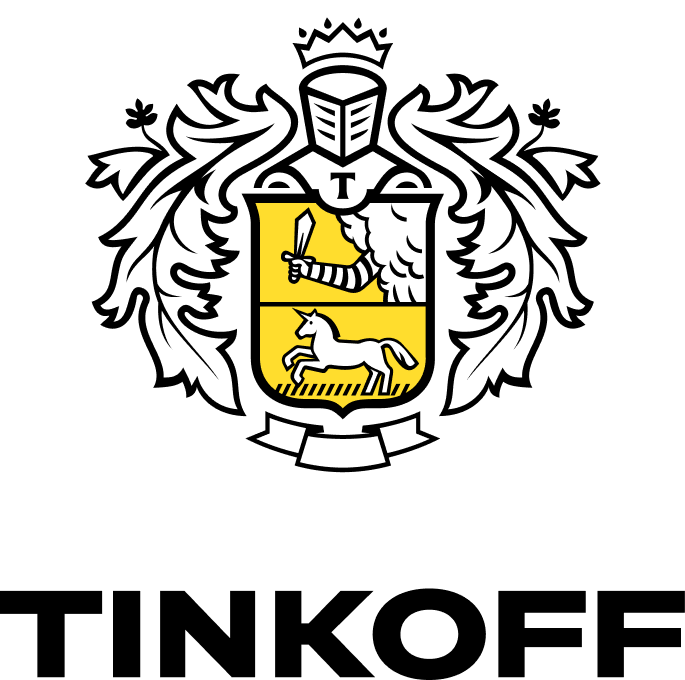

In [7]:
url = 'https://acdn.tinkoff.ru/static/documents/703d269e-ec01-4187-9544-5f01fb27bbb6.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

### Трансформации изображения

#### Обрезка по центру

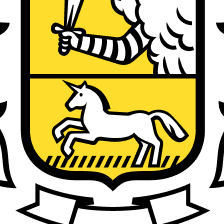

In [8]:
center = torchvision.transforms.functional.center_crop(img, [224, 224])
center

#### Преобразуем в оттенки серого

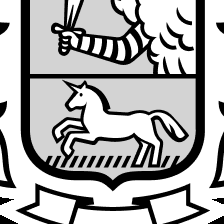

In [9]:
transform = torchvision.transforms.Grayscale()
gray_img = transform(center)
gray_img

#### Преобразуем в Tensor

In [10]:
to_tensor = torchvision.transforms.ToTensor()
tensor = to_tensor(gray_img)
tensor.shape

torch.Size([1, 224, 224])

### Среднее Tensor

In [11]:
tensor.mean()

tensor(0.6780)

## Задание 3

### 0. Скачивание DataSet

In [12]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2023-05-11 11:57:24--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.250.5, 13.224.250.113, 13.224.250.7, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.250.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  24.4MB/s    in 1.8s    

2023-05-11 11:57:26 (24.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!ls

In [14]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

### 1. Фиксирование random seed
https://pytorch.org/docs/stable/notes/randomness.html

In [15]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 2. Подготовка модели resnet18

In [16]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

### 3. Работа со слоями

In [17]:
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, 2)

In [18]:
for name, child in model.named_children(): 
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model.layer4.requires_grad_(True)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [45]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
class Model(torch.nn.Module):
  def __init__(self):
    super(model, self).__init__()

### 4. Подготовка данных

In [21]:
# Make transforms and use data loaders 

# We'll use these a lot, so make them variables 
mean_nums = [0.485, 0.456, 0.406] 
std_nums = [0.229, 0.224, 0.225] 
chosen_transforms = {
    'train': transforms.Compose([ 
        transforms.RandomResizedCrop(size=256), 
        transforms.RandomRotation(degrees=15), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize(mean_nums, std_nums) 
    ]), 
    'val': transforms.Compose([ 
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize(mean_nums, std_nums) 
    ]), 
}

In [22]:
# Set the directory for the data 
data_dir = './hymenoptera_data/' 
# Use the image folder function to create datasets 
chosen_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), chosen_transforms[x]) for x in ['train', 'val']
}

### 5. Создание загрузчика

In [23]:
# Make iterables with the dataloaders 
dataloaders = {
    x: torch.utils.data.DataLoader(
        chosen_datasets[x], 
        batch_size=64, 
        shuffle=True if x == 'train' else False, 
        num_workers=1
    ) for x in ['train', 'val']
}

In [24]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']} 
class_names = chosen_datasets['train'].classes 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Visualize some images 
def imshow(inp, title=None): 
  inp = inp.numpy().transpose((1, 2, 0)) 
  mean = np.array([mean_nums]) 
  std = np.array([std_nums]) 
  inp = std * inp + mean 
  inp = np.clip(inp, 0, 1) 
  plt.imshow(inp) 
  if title is not None: 
    plt.title(title)
  plt.pause(0.001) 
   # Pause a bit so that plots are updated

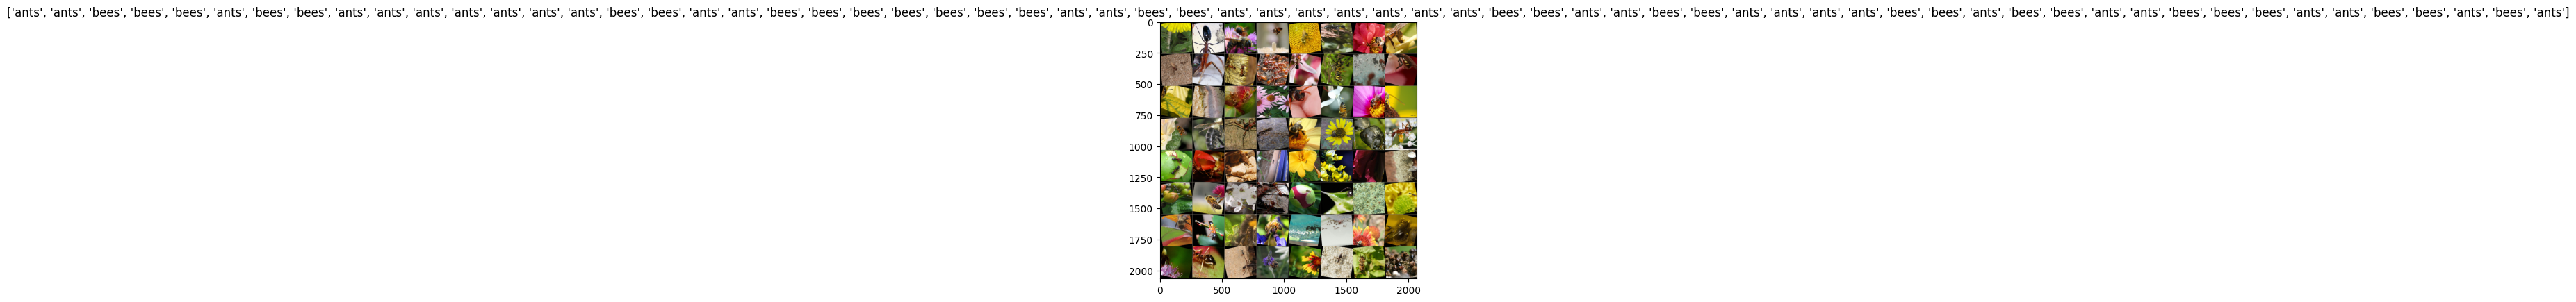

In [26]:
# Grab some of the training data to visualize 
inputs, classes = next(iter(dataloaders['train'])) 
# Now we construct a grid from batch 
out = torchvision.utils.make_grid(inputs) 
imshow(out, title=[class_names[x] for x in classes])

### 6. Оптимизатор

In [27]:
model = model.to(device) 
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

### 7. Функция потерь

In [28]:
criterion = torch.nn.CrossEntropyLoss() 

### 8. Тренировка модели

In [41]:
def train_model(model, criterion, optimizer, num_epochs=10): 
  since = time.time() 

  best_model_wts = copy.deepcopy(model.state_dict()) 
  best_acc = 0.0 
  
  for epoch in range(num_epochs): 
    print('Epoch {}/{}'.format(epoch, num_epochs - 1)) 
    print('-' * 10)
    
    # Each epoch has a training and validation phase 
    for phase in ['train', 'val']: 
      if phase == 'train': 
        model.train() # Set model to training mode 
      else: 
        model.eval() # Set model to evaluate mode 
      current_loss = 0.0 
      current_corrects = 0.0
      
      # Here's where the training happens 
      print('Iterating through data...') 
      for inputs, labels in dataloaders[phase]: 
        inputs = inputs.to(device) 
        labels = labels.to(device) 
        
        # We need to zero the gradients, don't forget it 
        optimizer.zero_grad() 
        
        # Time to carry out the forward training poss 
        # We only need to log the loss stats if we are in training phase 
        with torch.set_grad_enabled(phase == 'train'): 
          outputs = model(inputs) 
          _, preds = torch.max(outputs, 1) 
          loss = criterion(outputs, labels) 
          
          # backward + optimize only if in training phase 
          if phase == 'train': 
            loss.backward() 
            optimizer.step() 
            
            # We want variables to hold the loss statistics 
            current_loss += loss.item() * inputs.size(0) 
            current_corrects += torch.sum(preds == labels.data) 
        epoch_loss = current_loss / dataset_sizes[phase] 
        epoch_acc = current_corrects / dataset_sizes[phase] 
        print('{} Loss: {:.4f} Acc: {:.4f}'.format( phase, epoch_loss, epoch_acc)) 
        
        # Make a copy of the model if the accuracy on the validation set has improved 
        
        if phase == 'val' and epoch_acc > best_acc: 
          best_acc = epoch_acc 
          best_model_wts = copy.deepcopy(model.state_dict()) 
    print() 
  time_since = time.time() - since 
  print('Training complete in {:.0f}m {:.0f}s'.format( time_since // 60, time_since % 60)) 
  print('Best val Acc: {:4f}'.format(best_acc)) 
  
  # Now we'll load in the best model weights and return it 
  model.load_state_dict(best_model_wts) 
  return model

In [30]:
def visualize_model(model, num_images=6): 
  was_training = model.training 
  model.eval() 
  images_handeled = 0 
  fig = plt.figure() 
  
  with torch.no_grad(): 
    for i, (inputs, labels) in enumerate(dataloaders['val']): 
      inputs = inputs.to(device) 
      labels = labels.to(device) 

      outputs = model(inputs) 
      _, preds = torch.max(outputs, 1) 
      
      for j in range(inputs.size()[0]): 
        images_handeled += 1 
        ax = plt.subplot(num_images//2, 2, images_handeled) 
        ax.axis('off') 
        ax.set_title('predicted: {}'.format(class_names[preds[j]])) 
        imshow(inputs.cpu().data[j]) 
        
        if images_handeled == num_images: 
          model.train(mode=was_training) 
          return 
    model.train(mode=was_training)

Epoch 0/4
----------
Iterating through data...
train Loss: 0.1611 Acc: 0.1762
train Loss: 0.2937 Acc: 0.3852
train Loss: 0.4367 Acc: 0.5861
train Loss: 0.5565 Acc: 0.7418
Iterating through data...
val Loss: 0.0000 Acc: 0.0000
val Loss: 0.0000 Acc: 0.0000
val Loss: 0.0000 Acc: 0.0000

Epoch 1/4
----------
Iterating through data...
train Loss: 0.1415 Acc: 0.1967
train Loss: 0.2650 Acc: 0.4180
train Loss: 0.3797 Acc: 0.6475
train Loss: 0.4851 Acc: 0.8197
Iterating through data...
val Loss: 0.0000 Acc: 0.0000
val Loss: 0.0000 Acc: 0.0000
val Loss: 0.0000 Acc: 0.0000

Epoch 2/4
----------
Iterating through data...
train Loss: 0.1262 Acc: 0.2172
train Loss: 0.2630 Acc: 0.4098
train Loss: 0.3745 Acc: 0.6352
train Loss: 0.4695 Acc: 0.8115
Iterating through data...
val Loss: 0.0000 Acc: 0.0000
val Loss: 0.0000 Acc: 0.0000
val Loss: 0.0000 Acc: 0.0000

Epoch 3/4
----------
Iterating through data...
train Loss: 0.1315 Acc: 0.2090
train Loss: 0.2289 Acc: 0.4508
train Loss: 0.3405 Acc: 0.6803
train

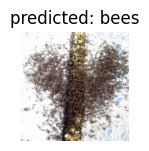

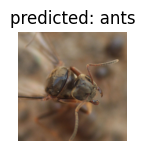

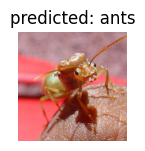

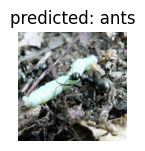

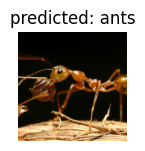

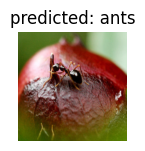

In [42]:
base_model = train_model(model, criterion, optimizer_ft, num_epochs=5) 
visualize_model(base_model) 
plt.show()

### 9. Получение финальных результатов